##### Effective degrees of freedom (xDF) of the Pearson's correlation coefficient under autocorrelation

Functional connectivity (FC), which refers to the temporal dependence between pairs of brain regions measured with fMRI, can be quantified using Pearson's correlation. However, this measure is biased if the timeseries themselves are autocorrelated, which is often the case with fMRI data because of low-frequency oscillatory patterns. The severity of this autocorrelation can vary depending on the size and location of measured brain regions.

To address the issue of autocorrelation, the xDF method was proposed by [Afyouni, Smith, and Nichols (2019)](https://www.sciencedirect.com/science/article/pii/S1053811919303945). This method addresses autocorrelation within each region as well as instantaneous and lagged cross-correlations between pairs of regions. Simulations under the null setting show that xDF correction provides better control of false positives compared to no correction or methods with more restrictive assumptions. Further, simulations with realistic autocorrelation and cross-correlation indicate that xDF has negligible bias.

Since the xDF method provides improved standard error estimates and control of false positives, the authors recommend applying this correction when computing FC statistics that rely on the standard errors of correlation coefficients. The most common example in FC is the Fisher Z-transform which is used to standardize the sampling distribution of correlation coefficients. However, this transformation assumes timepoints are independent and fails to stabilize variance under autocorrelation. This is an important note because these Z-scores are widely used to find significant correlations, threshold functional connectomes, and derive graph theory metrics. The following example motivates the use of xDF-corrected Z-scores (instead of Fisher's Z-scores) to improve inference on FC.

**1: retrieve the data and atlas parcellations**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from nilearn import connectome, datasets, image, maskers, plotting, regions
from scipy.spatial.distance import euclidean
from scipy.stats import norm

import ac_utils
import xdf

# fetch fMRIPrep functional data and confounds (from 33 subjects)
data = datasets.fetch_development_fmri(age_group="adult")
n_timepoints = image.load_img(data.func[-1]).shape[-1]

# fetch atlases, and assign each region of yeo atlas to a unique label
yeo = datasets.fetch_atlas_yeo_2011().thick_17
yeo, yeo_labels = regions.connected_label_regions(yeo, min_size=100, labels=np.arange(17))  # slow
power = datasets.fetch_coords_power_2011(legacy_format=False).rois[["x", "y", "z"]].to_numpy()

# resample whole-brain mask to the resolution of the fmri data (4mm)
mni = datasets.fetch_icbm152_2009()
mask = image.resample_to_img(mni.mask, data.func[0], interpolation="nearest")

# initialze maskers, standardize to N(0,1)
masker_kwargs = dict(standardize=True, memory="nilearn_cache")
masker_voxels = maskers.NiftiMasker(mask_img=mask, reports=False, **masker_kwargs)
masker_yeo = maskers.NiftiLabelsMasker(labels_img=yeo, reports=False, **masker_kwargs)
masker_power = maskers.NiftiSpheresMasker(seeds=power, radius=5, **masker_kwargs)


**2: compare autocorrelation of two regions** (Afyouni et al, 2019) Fig.1.E

Text(25, 0.1712140870390309, '95% CI')

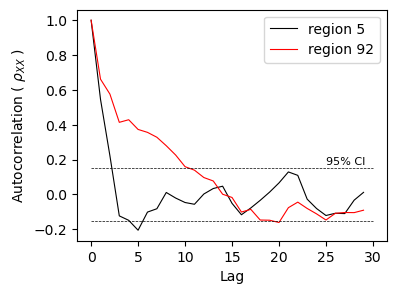

In [2]:
# extract mean timeseries from one run for each region of the yeo atlas
X = masker_yeo.fit_transform(data.func[-1], confounds=data.confounds[-1])

# calculate the full-lag autocorrelation function using FFT
X_ac, ci = ac_utils.ac_fft(X.T, n_timepoints)

# plot two example regions (first 30 lags)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(X_ac[5, :30], lw=0.8, c="k", label="region 5")
ax.plot(X_ac[92, :30], lw=0.8, c="r", label="region 92")
ax.legend()
ax.set_xlabel("Lag")
ax.set_ylabel(r"Autocorrelation ( $\rho_{XX}$ )")

# plot confidence intervals
ax.hlines(ci, 0, 30, lw=0.5, color="k", linestyle="dashed")
ax.text(25, ci[1] + 0.02, "95% CI", fontsize=8)


**3: extract the timeseries data from voxels and regions**

For each voxel/region in $X$, calculate the autocorrelation index (ACI) where $\rho_{XX,i}$ is the correlation of a timeseries with itself at lag $i$.

\begin{align*}
\tau_X = \sum_{i=0}^{N-1} \rho^2_{XX, i}
\end{align*}

In [3]:
# !!! 3 min runtime !!!


def calc_aci(X, n_timepoints):
    """return the autcorrelation index for each voxel/region"""
    X_ac, _ = ac_utils.ac_fft(X, n_timepoints)
    return np.sum(X_ac**2, axis=1)


aci = {"voxels": [], "yeo": [], "power": []}

# loop over subjects
for func, confounds in zip(data.func, data.confounds):

    # voxelwise autocorrelation index
    X_voxels = masker_voxels.fit_transform(func, confounds=confounds)
    aci["voxels"].append(calc_aci(X_voxels.T, n_timepoints))

    # yeo atlas autocorrelation index
    X_yeo = masker_yeo.fit_transform(func, confounds=confounds)
    aci["yeo"].append(calc_aci(X_yeo.T, n_timepoints))

    # power atlas autocorrelation index
    X_power = masker_power.fit_transform(func, confounds=confounds)
    aci["power"].append(calc_aci(X_power.T, n_timepoints))

# average across subjects
aci = {key: np.array(val).mean(axis=0) for key, val in aci.items()}


**4: map the variation in strength of autocorrelation over the brain, averaged across subjects** (Afyouni et al, 2019) Fig.2.A

The degree of autocorrelation in fMRI data is heterogeneous over the brain. Using a parcellation scheme magnifies this effect because of averaging voxels within regions - larger regions have a higher ACI. This demonstrates the importance of region-specific autocorrelation adjustment.

/usr/local/Caskroom/miniconda/base/envs/xdf/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


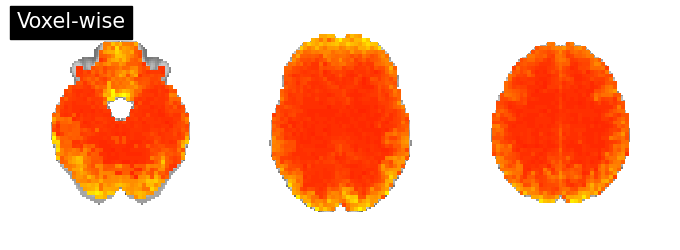

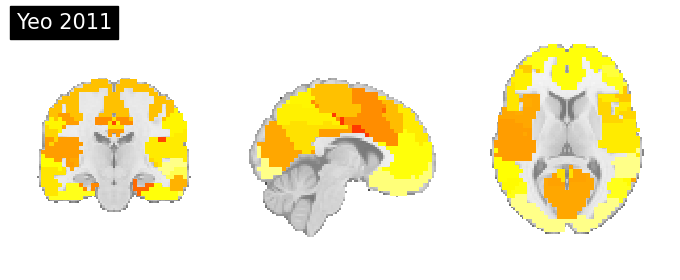

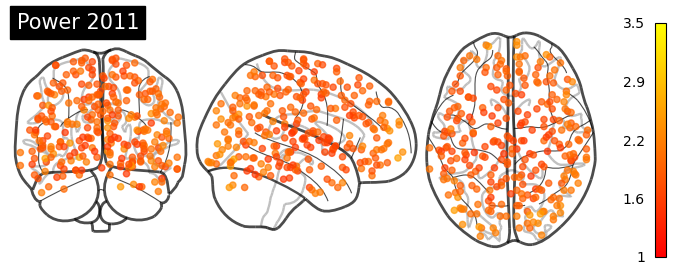

In [4]:
plot_kwargs = dict(threshold=1, vmax=3.5, annotate=False, draw_cross=False, colorbar=False)

# voxelwise autocorrelation index
plotting.plot_stat_map(
    masker_voxels.inverse_transform(aci["voxels"]),
    title="Voxel-wise",
    display_mode="z",
    cut_coords=(-20, 0, 30),
    **plot_kwargs,
)

# yeo atlas autocorrelation index
plotting.plot_stat_map(
    masker_yeo.inverse_transform(aci["yeo"]),
    title="Yeo 2011",
    **plot_kwargs,
)

# power atlas autocorrelation index
plotting.plot_markers(
    aci["power"],
    power,
    title="Power 2011",
    node_cmap="autumn",
    node_vmin=1,
    node_vmax=3.5,
    node_size=20,
    annotate=False,
)


**5: cortical regions have systematically higher autocorrelation than subcortical regions** (Afyouni et al, 2019) Fig.2.D

Plot ACI versus distance to the center of the brain (thalamus) using the Power atlas which has identically-sized spherical nodes.

Text(0, 0.5, 'Autocorrelation Index ($\\tau$)')

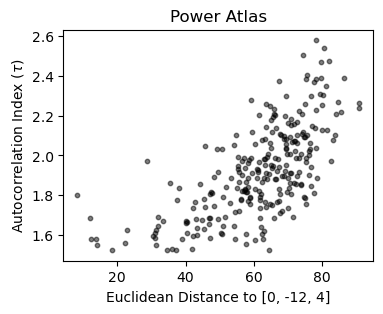

In [5]:
center = [0, -12, 4]  # thalamus coordinates

# calculate euclidean distance to thalamus for each region
distances = [euclidean(center, coords) for coords in power]

# plot results
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(distances, aci["power"], alpha=0.5, s=10, c="k")
ax.set_title("Power Atlas")
ax.set_xlabel(f"Euclidean Distance to {center}")
ax.set_ylabel(r"Autocorrelation Index ($\tau$)")


**6: larger regions have systematically higher autocorrelation than smaller regions** (Afyouni et al, 2019) Fig.2.C 

Plot ACI versus region size using the Yeo atlas defining 95 differently sized regions.

Text(0, 0.5, 'Autocorrelation Index ($\\tau$)')

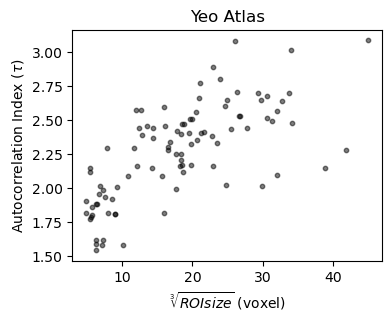

In [6]:
yeo_data = image.get_data(yeo)

# loop through yeo regions
sizes = [len(yeo_data[yeo_data == region]) ** (1 / 3) for region in np.unique(yeo_data)[1:]]

# plot results
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(sizes, aci["yeo"], alpha=0.5, s=10, c="k")
ax.set_title("Yeo Atlas")
ax.set_xlabel(r"$\sqrt[3]{ROI size}$ (voxel)")
ax.set_ylabel(r"Autocorrelation Index ($\tau$)")


**7: evaluate the false positive rate control for testing $\rho=0$ to illustrate the problem of inflated correlation estimates under autocorrelation**
(Afyouni et al, 2019) Fig.1.D

Ensure independence between timeseries by sampling regions in the analysis from two different subjects. This null realization is used to evaluate the distributions of Z-scores and the false positive rate (FPR). Due to the random nature of the fMRI timeseries between subjects, we expect 5% of the 95 correlation coefficients between timeseries from subject $u$ and subject $q$, to be significant at $\alpha=0.05$ (i.e $\approx$ 5 regions).

In [7]:
# swap `max_aci` between the two subjects
X_u = masker_yeo.fit_transform(data.func[0], confounds=data.confounds[0])  # first subject
X_p = masker_yeo.fit_transform(data.func[-1], confounds=data.confounds[-1])  # last subject

# from subject u, select the regions with the highest and lowest ACI
X_aci = calc_aci(X_u.T, n_timepoints)
max_aci = X_aci.argmax()
min_aci = X_aci.argmin()

# add those timeseries to subject p data matrix
X_null = np.concatenate((X_u[:, [min_aci, max_aci]], X_p), axis=1)


calc_xdf::: Time series standardised by their standard deviations.
calc_xdf::: AC Regularisation: Adaptive Truncation
calc_xdf::: NO truncation to the theoritical variance.


Text(0, 0.5, 'xDF Adjusted Z-scores')

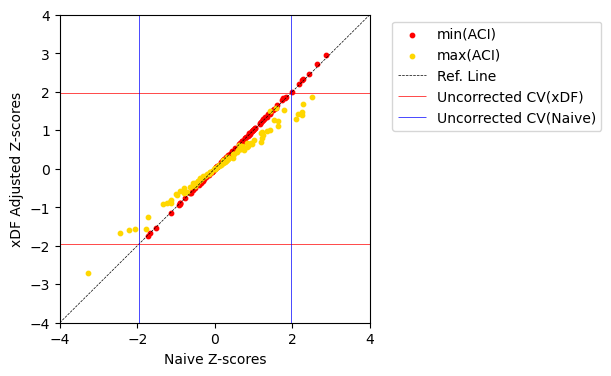

In [8]:
# apply xDF adjustment
xdf_null = xdf.calc_xdf(X_null.T, n_timepoints, truncate_variance=False)

# plot null column-vectors
fig, ax = plt.subplots(figsize=(4, 4))
limits = [-4, 4]
ax.scatter(xdf_null["znaive"][:, 0], xdf_null["z"][:, 0], s=10, c="r", label="min(ACI)")
ax.scatter(xdf_null["znaive"][:, 1], xdf_null["z"][:, 1], s=10, c="gold", label="max(ACI)")
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.plot(limits, limits, c="k", lw=0.5, ls="--", label="Ref. Line")

# add 95% (Z +/- 1.96) critical values
ax.hlines([-1.96, 1.96], *limits, lw=0.5, color="r", label="Uncorrected CV(xDF)")
ax.vlines([-1.96, 1.96], *limits, lw=0.5, color="b", label="Uncorrected CV(Naive)")
ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_xlabel("Naive Z-scores")
ax.set_ylabel("xDF Adjusted Z-scores")


**8: statistical and proportional thresholding**  (Afyouni et al, 2019) Fig.6.A  

Since the xDF correction is spatially heterogenous, both statistical and proportional thresholding methods are affected. For statistical thresholding (ST), a Benjamini-Hochberg FDR threshold at $\alpha=0.05$ is used to test the significance of each edge. For proportional thresholding (PT), 50% of the strongest connections are preserved. 

In [9]:
def fdr_threshold(z_vals, alpha):
    """Benjamini-Hochberg FDR threshold for the input z_vals (from nilearn.glm.fdr_threshold)"""
    assert z_vals.ndim == 1, "z_vals should be a vector"
    z_vals_ordered = -np.sort(-z_vals)  # max to min
    p_vals = norm.sf(z_vals_ordered)
    n_samples = len(p_vals)
    pos = p_vals < alpha * np.linspace(1 / n_samples, 1, n_samples)
    if pos.any():
        return z_vals_ordered[pos][-1] - 1.0e-12
    return np.infty


def proportional_threshold(z_vals, proportion):
    """proportional threshold (PT) to preserve a proportion (between 0-1) of the strongest connections"""
    assert z_vals.ndim == 1, "z_vals should be a vector"
    z_vals_ordered = np.sort(z_vals)  # min to max
    n_samples = len(z_vals_ordered)
    return z_vals_ordered[int(n_samples * proportion) - 1]


calc_xdf::: Time series standardised by their standard deviations.
calc_xdf::: AC Regularisation: Adaptive Truncation
calc_xdf::: NO truncation to the theoritical variance.


Text(0, 0.5, 'xDF Adjusted Z-scores')

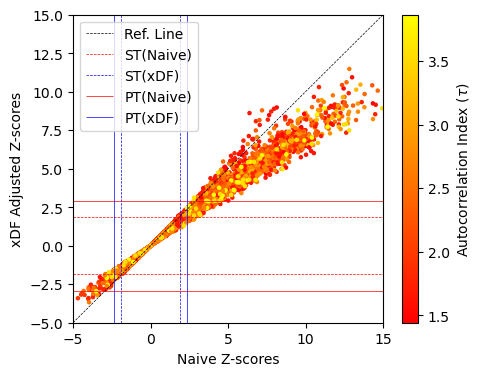

In [10]:
# apply xDF adjustment when the null not true
aci_ex = calc_aci(X_p.T, n_timepoints)  # last subject
xdf_ex = xdf.calc_xdf(X_p.T, n_timepoints, truncate_variance=False)
n_regions = aci_ex.size

# get lower triangle of connection weights
z_naive = connectome.sym_matrix_to_vec(xdf_ex["znaive"], discard_diagonal=True)
z_xdf = connectome.sym_matrix_to_vec(xdf_ex["z"], discard_diagonal=True)

# find FDR-controlling statistical threshold (ST)
st_naive = fdr_threshold(z_naive, alpha=0.05)
st_xdf = fdr_threshold(z_xdf, alpha=0.05)

# find proportional threshold (PT)
#   preserve 50% of the strongest connections
proportion = 0.50
pt_naive = proportional_threshold(z_naive, proportion)
pt_xdf = proportional_threshold(z_xdf, proportion)

# plot results
fig, ax = plt.subplots(figsize=(5, 4))
scatter = ax.scatter(z_naive, z_xdf, s=5, c=aci_ex.repeat(z_naive.size / n_regions), cmap="autumn")
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(r"Autocorrelation Index ($\tau$)")

limits = [-5, 15]
lw = 0.5
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.plot(limits, limits, c="k", lw=lw, ls="dashed", label="Ref. Line")

# add thresholds
ax.hlines([-st_naive, st_naive], *limits, ls="--", lw=lw, color="r", label="ST(Naive)")
ax.vlines([-st_xdf, st_xdf], *limits, ls="--", lw=lw, color="b", label="ST(xDF)")
ax.hlines([-pt_naive, pt_naive], *limits, lw=lw, color="r", label="PT(Naive)")
ax.vlines([-pt_xdf, pt_xdf], *limits, lw=lw, color="b", label="PT(xDF)")

ax.legend()
ax.set_xlabel("Naive Z-scores")
ax.set_ylabel("xDF Adjusted Z-scores")


**9: effects of autocorrelation correction on visualizing weighted networks**

This example shows that accounting for autocorrelation does influence the effects of thresholding, and the clustering structure of weighted networks.

Text(36.54684547115337, 0.5, 'Proportional\nthreshold')

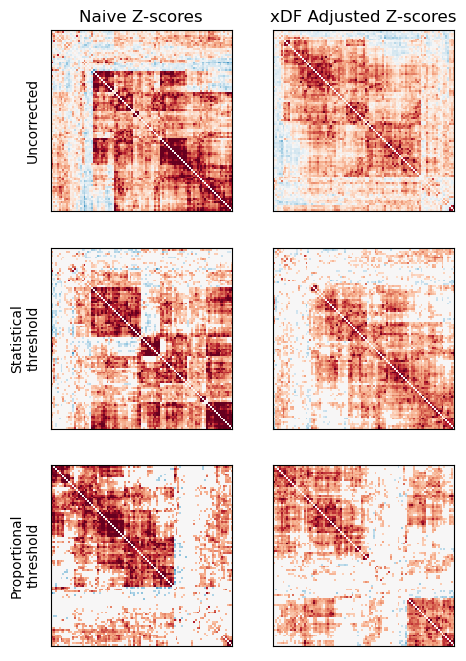

In [11]:
def threshold(z_vals, threshold):
    """return two-sided threshold"""
    z_vals = z_vals.copy()
    z_vals[np.abs(z_vals) < threshold] = 0.0
    return z_vals


# apply statistical threshold
z_naive_st = threshold(z_naive, st_naive)
z_xdf_st = threshold(z_xdf, st_xdf)

# apply proportional threshold
z_naive_pt = threshold(z_naive, pt_naive)
z_xdf_pt = threshold(z_xdf, pt_xdf)

# plot results
fig, axs = plt.subplots(3, 2, figsize=(5.25, 8))
axs = axs.flatten()

# apply a hierarchical clustering algorithm to visualize FC matrices
for idx, z_vec in enumerate([z_naive, z_xdf, z_naive_st, z_xdf_st, z_naive_pt, z_xdf_pt]):
    z_mat = connectome.vec_to_sym_matrix(z_vec, np.zeros(n_regions))
    plotting.plot_matrix(
        z_mat, labels=yeo_labels, axes=axs[idx], vmin=-10, vmax=10, reorder=True, colorbar=False
    )
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

# add labels
axs[0].set_title("Naive Z-scores")
axs[0].set_ylabel("Uncorrected")
axs[1].set_title("xDF Adjusted Z-scores")
axs[2].set_ylabel("Statistical\nthreshold")
axs[4].set_ylabel("Proportional\nthreshold")
